In [1]:
# IMPORTS & ENV VARS

import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import lightgbm as lgb
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import StandardScaler
import warnings

# suppress warnings for cleaner output
warnings.filterwarnings('ignore')

# set working directory to parent directory
curr_dir = os.getcwd()
parent_dir = os.path.dirname(curr_dir)
os.chdir(parent_dir)
print(f"Changed working directory to: {parent_dir}")

DATA_DIR = os.path.join(parent_dir, 'data')
RESULT_DIR = os.path.join(parent_dir, 'results')
                          
TRAIN_SPLIT_PER = 0.7
VAL_SPLIT_PER = 0.15

MIN_FEATURES_RFE = 50

LAG_WEEKS = [1, 2, 4, 8, 12]
DELTA_WEEKS = [1, 2, 4, 8, 12]
ROLLING_WEEKS = [4, 8, 12]

LGBM_PARAM_GRID = {
    'num_leaves': [31, 50],
    'learning_rate': [0.01, 0.05, 0.1],
    'n_estimators': [100, 200],
    'min_child_samples': [20, 30]
}

Changed working directory to: c:\term_project


In [2]:
# LOAD TRAIN DATA

train_features = pd.read_csv(os.path.join(DATA_DIR, 'dengue_features_train.csv'), index_col=[0, 1, 2])
train_labels = pd.read_csv(os.path.join(DATA_DIR, 'dengue_labels_train.csv'), index_col=[0, 1, 2])

# Seperate data for San Juan
sj_train_features = train_features.loc['sj']
sj_train_labels = train_labels.loc['sj']

# Separate data for Iquitos
iq_train_features = train_features.loc['iq']
iq_train_labels = train_labels.loc['iq']

print("San Juan")
print("features: ", sj_train_features.shape)
print("labels  : ", sj_train_labels.shape)

print("\nIquitos")
print("features: ", iq_train_features.shape)
print("labels  : ", iq_train_labels.shape)

San Juan
features:  (936, 21)
labels  :  (936, 1)

Iquitos
features:  (520, 21)
labels  :  (520, 1)


In [3]:
# PREPROCESS DATA 

def preprocess_city_data(features, labels=None):
    """
    Merges features and labels, converts week_start_date to index,
    and handles missing values.
    """
    # 1. Merge features and labels if labels are provided
    if labels is not None:
        df = features.join(labels)
    else:
        df = features.copy()
    
    # 2. Reset index to move 'year' and 'weekofyear' from index to columns
    # This preserves them as features.
    df.reset_index(inplace=True)
    
    # 3. Convert week_start_date to datetime
    df['week_start_date'] = pd.to_datetime(df['week_start_date'])
    
    # 4. Set week_start_date as index
    df.set_index('week_start_date', inplace=True)
    
    # 5. Drop 'city' column as it's constant for each model and not numeric
    if 'city' in df.columns:
        df.drop(columns=['city'], inplace=True)
    
    # 6. Fill Missing Values (Forward Fill then Backward Fill)
    df = df.ffill().bfill()
    
    return df

# Apply to San Juan and Iquitos
sj_train_full = preprocess_city_data(sj_train_features, sj_train_labels)
iq_train_full = preprocess_city_data(iq_train_features, iq_train_labels)

print("San Juan Preprocessed Shape:", sj_train_full.shape)
print("Iquitos Preprocessed Shape:", iq_train_full.shape)
sj_train_full.head()

San Juan Preprocessed Shape: (936, 23)
Iquitos Preprocessed Shape: (520, 23)


,year,weekofyear,ndvi_ne,ndvi_nw,ndvi_se,ndvi_sw,precipitation_amt_mm,reanalysis_air_temp_k,reanalysis_avg_temp_k,reanalysis_dew_point_temp_k,...,reanalysis_relative_humidity_percent,reanalysis_sat_precip_amt_mm,reanalysis_specific_humidity_g_per_kg,reanalysis_tdtr_k,station_avg_temp_c,station_diur_temp_rng_c,station_max_temp_c,station_min_temp_c,station_precip_mm,total_cases
week_start_date,,,,,,,,,,,,,,,,,,,,,
1990-04-30,1990,18,0.122600,0.103725,0.198483,0.177617,12.42,297.572857,297.742857,292.414286,...,73.365714,12.42,14.012857,2.628571,25.442857,6.900000,29.4,20.0,16.0,4
1990-05-07,1990,19,0.169900,0.142175,0.162357,0.155486,22.82,298.211429,298.442857,293.951429,...,77.368571,22.82,15.372857,2.371429,26.714286,6.371429,31.7,22.2,8.6,5
1990-05-14,1990,20,0.032250,0.172967,0.157200,0.170843,34.54,298.781429,298.878571,295.434286,...,82.052857,34.54,16.848571,2.300000,26.714286,6.485714,32.2,22.8,41.4,4
1990-05-21,1990,21,0.128633,0.245067,0.227557,0.235886,15.36,298.987143,299.228571,295.310000,...,80.337143,15.36,16.672857,2.428571,27.471429,6.771429,33.3,23.3,4.0,3
1990-05-28,1990,22,0.196200,0.262200,0.251200,0.247340,7.52,299.518571,299.664286,295.821429,...,80.460000,7.52,17.210000,3.014286,28.942857,9.371429,35.0,23.9,5.8,6


In [4]:
# SPLIT DATA (TRAIN / VAL / TEST)

def split_time_series(df, train_ratio=TRAIN_SPLIT_PER, val_ratio=VAL_SPLIT_PER):
    """
    Splits time series data into Train, Validation, and Test sets.
    """
    n = len(df)
    train_end = int(n * train_ratio)
    val_end = int(n * (train_ratio + val_ratio))
    
    train = df.iloc[:train_end]
    val = df.iloc[train_end:val_end]
    test = df.iloc[val_end:]
    
    return train, val, test

# Split San Juan
sj_train, sj_val, sj_test = split_time_series(sj_train_full)

# Split Iquitos
iq_train, iq_val, iq_test = split_time_series(iq_train_full)

print("San Juan Splits:")
print(f"Train: {sj_train.shape}, Val: {sj_val.shape}, Test: {sj_test.shape}")

print("\nIquitos Splits:")
print(f"Train: {iq_train.shape}, Val: {iq_val.shape}, Test: {iq_test.shape}")

San Juan Splits:
Train: (655, 23), Val: (140, 23), Test: (141, 23)

Iquitos Splits:
Train: (364, 23), Val: (78, 23), Test: (78, 23)


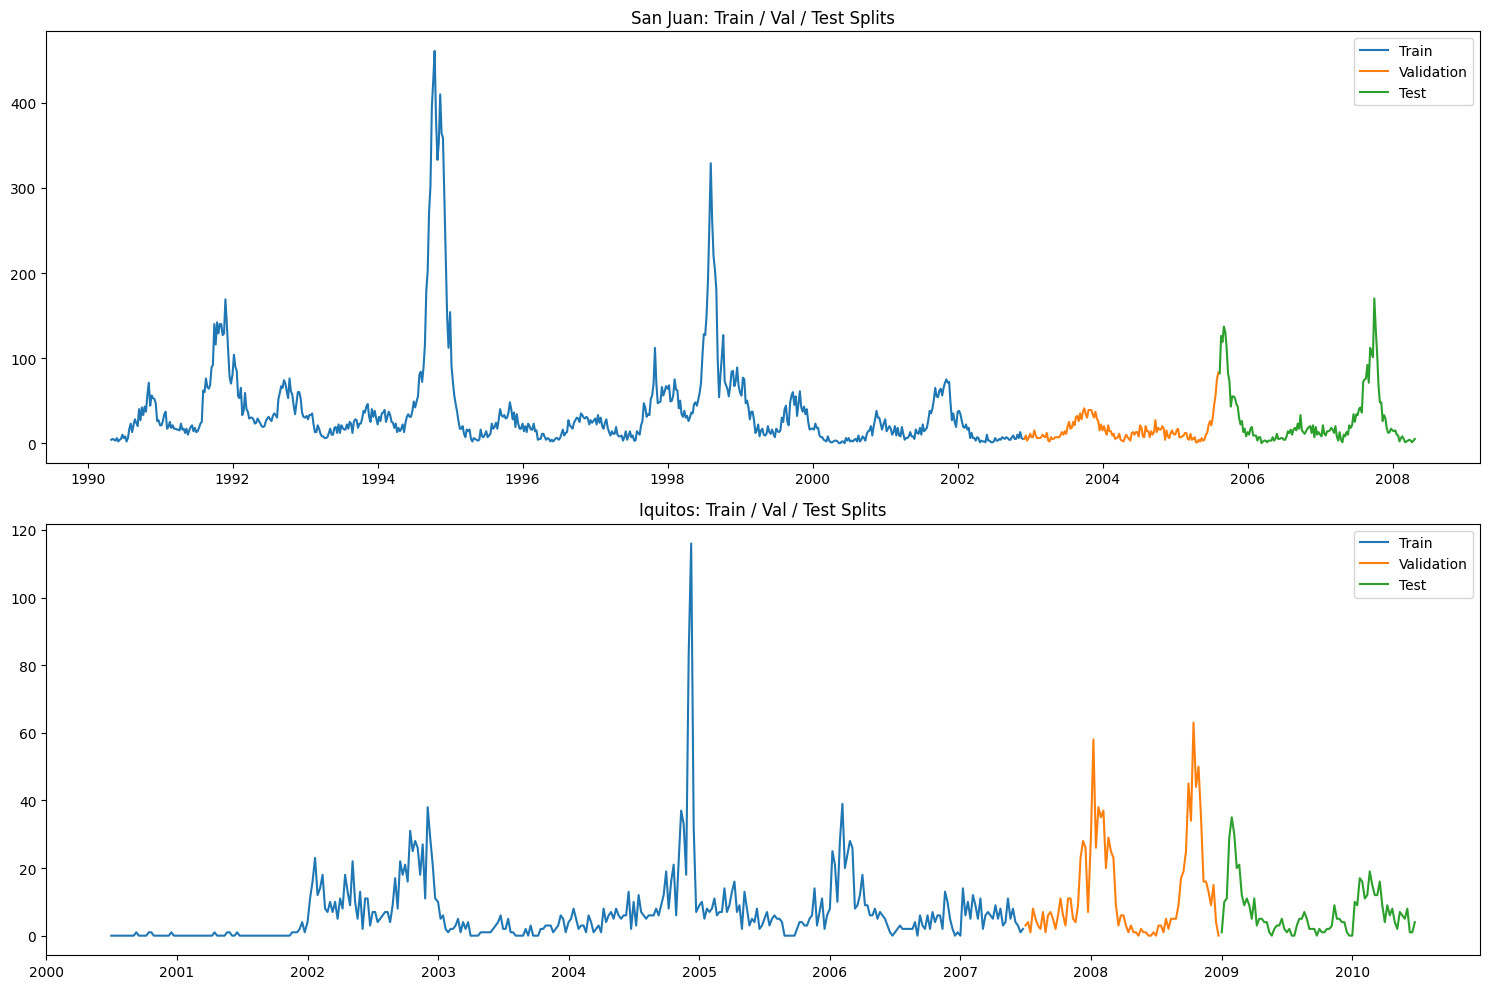

In [5]:
# VISUALIZE SPLITS

fig, ax = plt.subplots(2, 1, figsize=(15, 10))

# San Juan
ax[0].plot(sj_train.index, sj_train['total_cases'], label='Train')
ax[0].plot(sj_val.index, sj_val['total_cases'], label='Validation')
ax[0].plot(sj_test.index, sj_test['total_cases'], label='Test')
ax[0].set_title('San Juan: Train / Val / Test Splits')
ax[0].legend()

# Iquitos
ax[1].plot(iq_train.index, iq_train['total_cases'], label='Train')
ax[1].plot(iq_val.index, iq_val['total_cases'], label='Validation')
ax[1].plot(iq_test.index, iq_test['total_cases'], label='Test')
ax[1].set_title('Iquitos: Train / Val / Test Splits')
ax[1].legend()

plt.tight_layout()
plt.show()

In [6]:
# FEATURE EXTRACTION

def create_features(df, history_df=None, lag_weeks=LAG_WEEKS, delta_weeks=DELTA_WEEKS, rolling_weeks=ROLLING_WEEKS):
    """
    Creates lag, delta, and rolling window features.
    If history_df is provided, it is prepended to df to calculate features for the beginning of df.
    """
    # Determine max window size needed
    max_window = max(max(lag_weeks), max(rolling_weeks)) + 1
    
    # Prepare dataframe for engineering
    if history_df is not None:
        # Take tail of history
        history_tail = history_df.tail(max_window)
        # Concatenate
        df_eng = pd.concat([history_tail, df])
    else:
        df_eng = df.copy()
    
    # List of columns to create features for (exclude labels and non-numeric if any)
    feature_cols = [c for c in df.columns if c not in ['total_cases', 'year', 'weekofyear']]
    
    new_features = []
    
    for col in feature_cols:
        # Lag features
        for lag in lag_weeks:
            new_features.append(
                df_eng[col].shift(lag).rename(f'{col}_lag_{lag}')
            )
            
        # Delta features
        for delta in delta_weeks:
            new_features.append(
                df_eng[col].diff(delta).rename(f'{col}_delta_{delta}')
            )
            
        # Rolling features
        for window in rolling_weeks:
            rolling_col = df_eng[col].rolling(window=window)
            
            roll_mean = rolling_col.mean()
            roll_std = rolling_col.std()
            
            new_features.append(roll_mean.rename(f'{col}_rolling_mean_{window}'))
            new_features.append(roll_std.rename(f'{col}_rolling_std_{window}'))
            new_features.append(rolling_col.min().rename(f'{col}_rolling_min_{window}'))
            new_features.append(rolling_col.max().rename(f'{col}_rolling_max_{window}'))
            new_features.append(rolling_col.kurt().rename(f'{col}_rolling_kurt_{window}'))
            
            # Z-score: How many standard deviations the current value is from the rolling mean
            # This captures "how std deviation deviate from mean" for the current instance
            z_score = (df_eng[col] - roll_mean) / (roll_std + 1e-8)
            new_features.append(z_score.rename(f'{col}_rolling_zscore_{window}'))
            
    # Concatenate all new features
    if new_features:
        df_features = pd.concat(new_features, axis=1)
        df_eng = pd.concat([df_eng, df_features], axis=1)
            
    # If history was used, slice back to original df index
    if history_df is not None:
        df_eng = df_eng.loc[df.index]
    else:
        # If no history (start of train), drop NaNs
        df_eng.dropna(inplace=True)
    
    return df_eng

# Apply to San Juan
print("Feature Engineering San Juan...")
sj_train_eng = create_features(sj_train)
sj_val_eng = create_features(sj_val, history_df=sj_train)
# For test, history is train + val
sj_train_val = pd.concat([sj_train, sj_val])
sj_test_eng = create_features(sj_test, history_df=sj_train_val)

# Apply to Iquitos
print("Feature Engineering Iquitos...")
iq_train_eng = create_features(iq_train)
iq_val_eng = create_features(iq_val, history_df=iq_train)
iq_train_val = pd.concat([iq_train, iq_val])
iq_test_eng = create_features(iq_test, history_df=iq_train_val)

print("San Juan Shapes (Train/Val/Test):", sj_train_eng.shape, sj_val_eng.shape, sj_test_eng.shape)
print("Iquitos Shapes (Train/Val/Test):", iq_train_eng.shape, iq_val_eng.shape, iq_test_eng.shape)

Feature Engineering San Juan...
Feature Engineering Iquitos...
San Juan Shapes (Train/Val/Test): (643, 583) (140, 583) (141, 583)
Iquitos Shapes (Train/Val/Test): (352, 583) (78, 583) (78, 583)


In [7]:
# RECURSIVE FEATURE ELIMINATION (RFE)

def recursive_feature_elimination(X_train, y_train, X_val, y_val, min_features=MIN_FEATURES_RFE, verbose=True):
    """
    Starts with all features and removes the least important one iteratively.
    Tracks the best subset of features based on Validation MAE.
    Stops when min_features is reached.
    """
    current_features = X_train.columns.tolist()
    best_features = current_features.copy()
    best_mae = float('inf')
    
    # Define a fixed model for selection
    # Using 'poisson' objective as requested
    params = {
        'objective': 'poisson',
        'metric': 'mae',
        'n_estimators': 100,
        'learning_rate': 0.1,
        'num_leaves': 31,
        'random_state': 42,
        'verbosity': -1,
        'n_jobs': -1
    }
    
    print(f"Starting Recursive Feature Elimination on {len(current_features)} features (stopping at {min_features})...")
    
    # Loop until we reach min_features
    while len(current_features) >= min_features:
        # Train model
        model = lgb.LGBMRegressor(**params)
        model.fit(X_train[current_features], y_train)
        
        # Predict
        preds = model.predict(X_val[current_features])
        preds = np.maximum(preds, 0)
        
        mae = mean_absolute_error(y_val, preds)
        
        # Print progress occasionally
        if verbose and (len(current_features) % 10 == 0 or len(current_features) < (min_features + 10)):
             print(f"Features: {len(current_features):<3} MAE: {mae:.4f}")
            
        if mae < best_mae:
            best_mae = mae
            best_features = current_features.copy()
            if verbose:
                print(f"   -> New Best MAE at {len(current_features)} features: {best_mae:.4f}")
        
        # If we are at min_features, we stop here (after evaluation)
        if len(current_features) == min_features:
            break

        # Get feature importances
        importances = model.feature_importances_
        
        # Find index of least important feature
        # If multiple have 0 importance, this picks the first one
        least_important_idx = np.argmin(importances)
        least_important_feature = current_features[least_important_idx]
        
        # Remove it
        current_features.remove(least_important_feature)
        
    print(f"Selected {len(best_features)} features. Final MAE: {best_mae:.4f}")
    return best_features

In [8]:
# PREPARE X and y MATRICES & SELECT FEATURES

def prepare_xy(df, target_col='total_cases'):
    X = df.drop(columns=[target_col])
    y = df[target_col]
    return X, y

# San Juan
X_train_sj, y_train_sj = prepare_xy(sj_train_eng)
X_val_sj, y_val_sj = prepare_xy(sj_val_eng)
X_test_sj, y_test_sj = prepare_xy(sj_test_eng)

# No Log Transformation - using Poisson objective

# Iquitos
X_train_iq, y_train_iq = prepare_xy(iq_train_eng)
X_val_iq, y_val_iq = prepare_xy(iq_val_eng)
X_test_iq, y_test_iq = prepare_xy(iq_test_eng)

print("San Juan X Shapes (Before Selection):", X_train_sj.shape)
print("Iquitos X Shapes (Before Selection):", X_train_iq.shape)

# Apply Recursive Feature Elimination
print("\n--- Feature Selection San Juan ---")
sj_kept_cols = recursive_feature_elimination(X_train_sj, y_train_sj, X_val_sj, y_val_sj)

print("\n--- Feature Selection Iquitos ---")
iq_kept_cols = recursive_feature_elimination(X_train_iq, y_train_iq, X_val_iq, y_val_iq)

# Update Matrices with Selected Features
X_train_sj = X_train_sj[sj_kept_cols]
X_val_sj = X_val_sj[sj_kept_cols]
X_test_sj = X_test_sj[sj_kept_cols]

X_train_iq = X_train_iq[iq_kept_cols]
X_val_iq = X_val_iq[iq_kept_cols]
X_test_iq = X_test_iq[iq_kept_cols]

print("\nSan Juan Selected Shape:", X_train_sj.shape)
print("Iquitos Selected Shape:", X_train_iq.shape)

San Juan X Shapes (Before Selection): (643, 582)
Iquitos X Shapes (Before Selection): (352, 582)

--- Feature Selection San Juan ---
Starting Recursive Feature Elimination on 582 features (stopping at 50)...
   -> New Best MAE at 582 features: 7.9533
Features: 580 MAE: 7.9533
Features: 570 MAE: 7.9533
Features: 560 MAE: 7.9533
Features: 550 MAE: 7.9533
Features: 540 MAE: 7.9533
Features: 530 MAE: 7.9533
Features: 520 MAE: 7.9533
Features: 510 MAE: 7.9533
Features: 500 MAE: 7.9533
Features: 490 MAE: 7.9533
Features: 480 MAE: 7.9533
Features: 470 MAE: 7.9533
Features: 460 MAE: 8.0835
Features: 450 MAE: 8.0835
Features: 440 MAE: 8.0835
Features: 430 MAE: 8.0266
   -> New Best MAE at 422 features: 7.9312
Features: 420 MAE: 7.9312
Features: 410 MAE: 7.9312
Features: 400 MAE: 7.9312
Features: 390 MAE: 8.1073
Features: 380 MAE: 8.1895
Features: 370 MAE: 8.3669
Features: 360 MAE: 8.3360
Features: 350 MAE: 8.4302
Features: 340 MAE: 8.3121
Features: 330 MAE: 8.1382
Features: 320 MAE: 8.3267
   -

In [9]:
X_train_iq.head()

,year,reanalysis_dew_point_temp_k,ndvi_ne_rolling_kurt_4,ndvi_ne_rolling_max_8,ndvi_ne_rolling_min_12,ndvi_se_lag_8,ndvi_se_rolling_mean_8,ndvi_se_rolling_min_12,ndvi_se_rolling_max_12,ndvi_se_rolling_kurt_12,...,station_min_temp_c_rolling_std_12,station_min_temp_c_rolling_zscore_12,station_precip_mm_lag_1,station_precip_mm_lag_4,station_precip_mm_lag_8,station_precip_mm_lag_12,station_precip_mm_rolling_std_4,station_precip_mm_rolling_min_4,station_precip_mm_rolling_mean_8,station_precip_mm_rolling_std_12
week_start_date,,,,,,,,,,,,,,,,,,,,,
2000-09-23,2000,292.707143,-3.954082,0.408157,0.176757,0.254371,0.347538,0.204114,0.406714,-1.358780,...,1.932184,0.500298,18.9,89.2,4.0,3.0,36.034520,18.9,60.2125,31.567211
2000-09-30,2000,293.217143,2.074935,0.408157,0.175686,0.231671,0.346794,0.204114,0.406714,-1.662273,...,1.916179,0.517523,104.2,78.0,11.5,55.6,34.908297,18.9,66.0125,31.606073
2000-10-07,2000,294.664286,1.259002,0.408157,0.175686,0.380586,0.333908,0.225714,0.406714,-1.620482,...,1.887037,0.291462,57.9,56.9,72.9,38.1,34.891546,18.9,64.7750,31.501154
2000-10-14,2000,294.592857,-4.412362,0.408157,0.175686,0.341780,0.334910,0.225714,0.406714,-1.355408,...,1.194780,0.857898,63.0,18.9,50.1,30.0,41.555776,3.0,58.8875,34.150070
2000-10-21,2000,294.007143,-0.909817,0.348814,0.175686,0.406714,0.330814,0.225714,0.406714,-0.749936,...,1.194178,0.725743,3.0,104.2,89.2,4.0,27.232012,3.0,53.3875,30.937131


In [10]:
X_test_sj.head()

,year,weekofyear,ndvi_nw,ndvi_ne_lag_4,ndvi_ne_delta_4,ndvi_ne_rolling_std_8,ndvi_ne_rolling_max_8,ndvi_ne_rolling_std_12,ndvi_ne_rolling_min_12,ndvi_ne_rolling_max_12,...,station_min_temp_c_rolling_kurt_12,station_precip_mm_lag_8,station_precip_mm_lag_12,station_precip_mm_delta_1,station_precip_mm_delta_4,station_precip_mm_rolling_min_8,station_precip_mm_rolling_kurt_8,station_precip_mm_rolling_min_12,station_precip_mm_rolling_kurt_12,station_precip_mm_rolling_zscore_12
week_start_date,,,,,,,,,,,,,,,,,,,,,
2005-08-13,2005,32,0.023650,0.05140,-0.11615,0.079631,0.0892,0.068603,-0.1087,0.0892,...,-1.014371,44.5,110.9,-28.4,-40.2,0.0,-0.095490,0.0,-0.885407,-1.069496
2005-08-20,2005,33,0.069675,-0.06650,0.11440,0.079902,0.0892,0.068619,-0.1087,0.0892,...,-1.163141,0.0,71.2,5.5,-32.2,12.6,-0.312107,0.0,-0.794321,-0.710171
2005-08-27,2005,34,0.051000,-0.10870,-0.01370,0.079722,0.0854,0.078332,-0.1224,0.0892,...,0.335067,52.3,23.9,13.6,-42.1,12.6,-0.025290,0.0,-0.672282,-0.134522
2005-09-03,2005,35,-0.007300,-0.06475,-0.05765,0.069886,0.0514,0.083082,-0.1224,0.0892,...,0.100975,34.8,4.4,72.7,63.4,12.6,0.523462,0.0,1.131490,2.201589
2005-09-10,2005,36,-0.027100,-0.06475,0.06695,0.060605,0.0479,0.081152,-0.1224,0.0892,...,0.413530,52.8,44.5,-95.5,-3.7,8.9,0.326150,0.0,0.682103,-1.054413


In [11]:
# TRAIN BASELINE MODELS
# Train on Train, Evaluate on Validation

def train_evaluate_lgbm(X_train, y_train, X_val, y_val, params=None):
    """
    Trains a LightGBM model and evaluates it on validation set.
    """
    if params is None:
        params = {
            'objective': 'poisson',
            'metric': 'mae',
            'n_estimators': 1000, 
            'learning_rate': 0.05,
            'num_leaves': 31,
            'random_state': 42,
            'verbosity': -1
        }
        
    model = lgb.LGBMRegressor(**params)
    
    # Train with early stopping
    callbacks = [lgb.early_stopping(stopping_rounds=50)]
    
    model.fit(X_train, y_train, 
              eval_set=[(X_train, y_train), (X_val, y_val)],
              eval_metric='mae',
              callbacks=callbacks)
    
    # Predict on Validation
    predictions = model.predict(X_val)
    predictions = np.maximum(predictions, 0)
    
    # Evaluate
    mae = mean_absolute_error(y_val, predictions)
    
    return model, mae, predictions

# Train Baseline Models
print("Training San Juan Baseline...")
model_sj, mae_sj, preds_sj = train_evaluate_lgbm(X_train_sj, y_train_sj, X_val_sj, y_val_sj)
print(f"San Juan Validation MAE: {mae_sj:.4f}")

print("\nTraining Iquitos Baseline...")
model_iq, mae_iq, preds_iq = train_evaluate_lgbm(X_train_iq, y_train_iq, X_val_iq, y_val_iq)
print(f"Iquitos Validation MAE: {mae_iq:.4f}")

Training San Juan Baseline...
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[354]	training's l1: 0.924004	valid_1's l1: 7.60122
San Juan Validation MAE: 7.6012

Training Iquitos Baseline...
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[65]	training's l1: 2.52711	valid_1's l1: 9.52214
Iquitos Validation MAE: 9.5221


In [12]:
# HYPERPARAMETER TUNING (MANUAL GRID SEARCH)

def tune_lgbm_manual(X_train, y_train, X_val, y_val):
    """
    Performs Manual Grid Search using fixed Train/Val split.
    """
    from itertools import product
    
    param_grid = LGBM_PARAM_GRID
    keys, values = zip(*param_grid.items())
    combinations = [dict(zip(keys, v)) for v in product(*values)]
    
    best_mae = float('inf')
    best_params = None
    best_model = None
    
    print(f"Testing {len(combinations)} combinations...")
    
    for i, params in enumerate(combinations):
        # Add fixed params
        current_params = params.copy()
        current_params.update({
            'objective': 'poisson',
            'metric': 'mae',
            'random_state': 42,
            'verbosity': -1,
            'n_estimators': 1000 # Use early stopping
        })
        
        model = lgb.LGBMRegressor(**current_params)
        
        callbacks = [lgb.early_stopping(stopping_rounds=20, verbose=False)]
        
        model.fit(X_train, y_train, 
                  eval_set=[(X_val, y_val)],
                  eval_metric='mae',
                  callbacks=callbacks)
        
        preds = model.predict(X_val)
        preds = np.maximum(preds, 0)
        mae = mean_absolute_error(y_val, preds)
        
        if mae < best_mae:
            best_mae = mae
            best_params = params
            best_model = model
            # print(f"New Best MAE: {best_mae:.4f} with {params}")
            
    print("\nBest Parameters:", best_params)
    print("Best Validation MAE:", best_mae)
    
    return best_model, best_params

# Tune San Juan
print("Tuning San Juan Model...")
best_model_sj, best_params_sj = tune_lgbm_manual(X_train_sj, y_train_sj, X_val_sj, y_val_sj)

# Tune Iquitos
print("\nTuning Iquitos Model...")
best_model_iq, best_params_iq = tune_lgbm_manual(X_train_iq, y_train_iq, X_val_iq, y_val_iq)

Tuning San Juan Model...
Testing 24 combinations...

Best Parameters: {'num_leaves': 31, 'learning_rate': 0.01, 'n_estimators': 100, 'min_child_samples': 30}
Best Validation MAE: 6.822450033396068

Tuning Iquitos Model...
Testing 24 combinations...

Best Parameters: {'num_leaves': 31, 'learning_rate': 0.1, 'n_estimators': 100, 'min_child_samples': 20}
Best Validation MAE: 9.46834090114627


San Juan Test Set MAE: 17.1352
Iquitos Test Set MAE: 5.2919


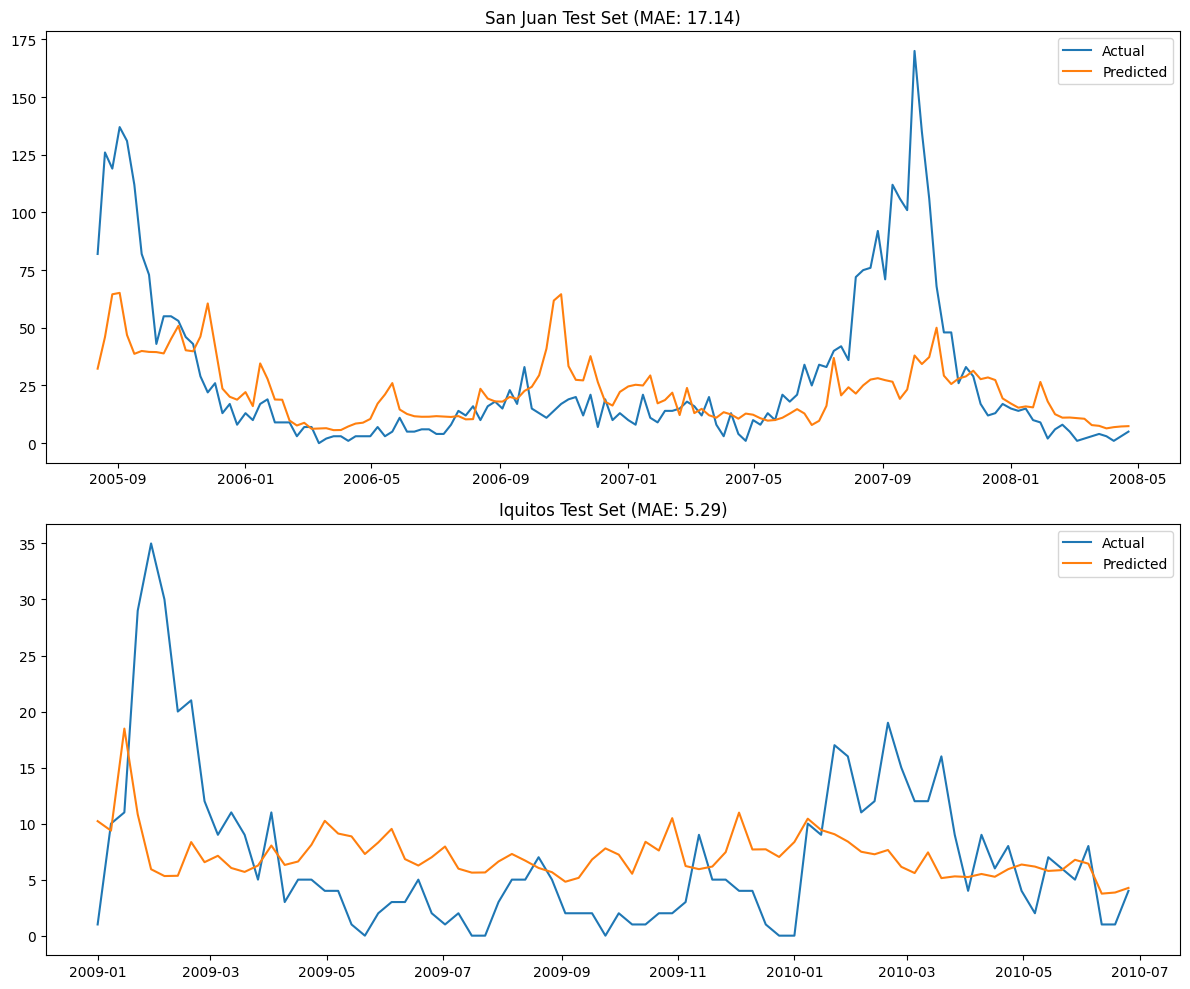

In [13]:
# EVALUATION ON TEST SET (HOLDOUT)

# Evaluate Tuned San Juan on Test Set
preds_sj_test = best_model_sj.predict(X_test_sj)
preds_sj_test = np.maximum(preds_sj_test, 0)
mae_sj_test = mean_absolute_error(y_test_sj, preds_sj_test)
print(f"San Juan Test Set MAE: {mae_sj_test:.4f}")

# Evaluate Tuned Iquitos on Test Set
preds_iq_test = best_model_iq.predict(X_test_iq)
preds_iq_test = np.maximum(preds_iq_test, 0)
mae_iq_test = mean_absolute_error(y_test_iq, preds_iq_test)
print(f"Iquitos Test Set MAE: {mae_iq_test:.4f}")

# Plot Results
fig, ax = plt.subplots(2, 1, figsize=(12, 10))

# San Juan
ax[0].plot(y_test_sj.index, y_test_sj, label='Actual')
ax[0].plot(y_test_sj.index, preds_sj_test, label='Predicted')
ax[0].set_title(f'San Juan Test Set (MAE: {mae_sj_test:.2f})')
ax[0].legend()

# Iquitos
ax[1].plot(y_test_iq.index, y_test_iq, label='Actual')
ax[1].plot(y_test_iq.index, preds_iq_test, label='Predicted')
ax[1].set_title(f'Iquitos Test Set (MAE: {mae_iq_test:.2f})')
ax[1].legend()

plt.tight_layout()
plt.show()

In [ ]:
# FINAL MODEL TRAINING & SUBMISSION

# 1. Train Final Models on ALL Data (Train + Val + Test)
# We need to combine the engineered features
X_full_sj = pd.concat([X_train_sj, X_val_sj, X_test_sj])
y_full_sj = pd.concat([y_train_sj, y_val_sj, y_test_sj])

X_full_iq = pd.concat([X_train_iq, X_val_iq, X_test_iq])
y_full_iq = pd.concat([y_train_iq, y_val_iq, y_test_iq])

print("Training Final San Juan Model on full data...")
final_params_sj = best_params_sj.copy()
final_params_sj.update({'objective': 'poisson', 'metric': 'mae', 'random_state': 42, 'verbosity': -1})
# Increase estimators slightly or use the best_iteration from tuning if available, 
# but since we have more data, maybe just use a fixed reasonable number or the one from grid search
final_model_sj = lgb.LGBMRegressor(**final_params_sj)
final_model_sj.fit(X_full_sj, y_full_sj)

print("Training Final Iquitos Model on full data...")
final_params_iq = best_params_iq.copy()
final_params_iq.update({'objective': 'poisson', 'metric': 'mae', 'random_state': 42, 'verbosity': -1})
final_model_iq = lgb.LGBMRegressor(**final_params_iq)
final_model_iq.fit(X_full_iq, y_full_iq)


# 2. Load and Preprocess Submission Data
test_features = pd.read_csv(os.path.join(DATA_DIR, 'dengue_features_test.csv'), index_col=[0, 1, 2])
sj_sub_features = test_features.loc['sj']
iq_sub_features = test_features.loc['iq']

sj_sub_pre = preprocess_city_data(sj_sub_features)
iq_sub_pre = preprocess_city_data(iq_sub_features)

# 3. Feature Engineering for Submission (Using Full Train History)
# We need the tail of the FULL training data (Train+Val+Test)
sj_full_raw = pd.concat([sj_train, sj_val, sj_test])
iq_full_raw = pd.concat([iq_train, iq_val, iq_test])

print("Generating Submission Features...")
sj_sub_eng = create_features(sj_sub_pre, history_df=sj_full_raw)
iq_sub_eng = create_features(iq_sub_pre, history_df=iq_full_raw)

# 4. Align Features (Select kept columns)
sj_sub_eng = sj_sub_eng[sj_kept_cols]
iq_sub_eng = iq_sub_eng[iq_kept_cols]

print("San Juan Submission Shape:", sj_sub_eng.shape)
print("Iquitos Submission Shape:", iq_sub_eng.shape)

# 5. Predict
# Drop total_cases from features as it is the target (and not present in X_train)
if 'total_cases' in sj_sub_eng.columns:
    sj_sub_eng = sj_sub_eng.drop(columns=['total_cases'])

sj_preds_final = final_model_sj.predict(sj_sub_eng)
sj_preds_final = np.maximum(sj_preds_final, 0).astype(int)

if 'total_cases' in iq_sub_eng.columns:
    iq_sub_eng = iq_sub_eng.drop(columns=['total_cases'])

iq_preds_final = final_model_iq.predict(iq_sub_eng)
iq_preds_final = np.maximum(iq_preds_final, 0).astype(int)

# 6. Create Submission
submission = pd.read_csv(os.path.join(DATA_DIR, "submission_format.csv"), index_col=[0, 1, 2])

submission.loc['sj', 'total_cases'] = sj_preds_final
submission.loc['iq', 'total_cases'] = iq_preds_final

# 7. Save
submission_path = os.path.join(parent_dir, 'results', 'submission_lightgbm_5.csv')
submission.to_csv(submission_path)
print(f"Submission saved to {submission_path}")
submission.head()